# Loading libraries

In [1]:
# There are loaded from the redo_venv.sh in the root directory
# Note, venv needs to be in the root directory for vscode to find it
import pandas as pd 
import wandb
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import itertools
from pathlib import Path
from typing import List
import shutil
import re


# Configuration

This is the top level configuration.  This should be all that you need to change to run this on new experiments.  Of course, if you want different 
figures then you will also need to change the Processing section.

In [2]:
# Whether to download again or not 
download = False

# Contact the wandb api and download stuff
api = wandb.Api()
entity, project = "rcpaffenroth-wpi", "arxiv-20-epoch-6-7-2023"  
wandb_path = entity + "/" + project

# All the possible types of runs
datas = ['medium', 'both_uniform', 'both_random']
models = ['RNN', 'sequential2D_MLP', 'sequential2D_dense', 'sequential2D_sparse']
eval_losses = ['last', 'all']
# datas = ['both_uniform']
# models = ['sequential2D_sparse']
# eval_losses = ['all']

# High-level plotting parameters
my_colors = mcolors.TABLEAU_COLORS



# Functions

In [3]:

def get_run_set(model: str, data: str, eval_loss: str) -> List[wandb.apis.public.Run]:
    # Get the run set with the given filters
    # This is the whole experiment!  
    runs = api.runs(wandb_path, filters={"config.model/name": model, "config.data/name": data, "config.data/evaluate_loss": eval_loss})
    return runs

def get_run_history(run: wandb.apis.public.Run, losses: List[str]):
    # From the run we just want to extract the various losses.
    data = {loss: [] for loss in losses}    
    for row in run.scan_history():
        # This will be a row with all the losses for that step
        # We only want the ones in losses
        for loss in losses:
            data[loss].append(row[loss])
    # Convert to a np array
    for loss in losses:
        tmp = [np.nan if v is None else v for v in data[loss]]
        data[loss] = np.array(tmp)
    return data

def setup_plot(title='', ylabel='', ax=None, ylim=None, yscale='linear') -> plt.Axes:
    if ax is None:
        ax = plt.gca()
    if ylim is not None:
        ax.set_ylim(ylim)
    if yscale == 'log':
        ax.set_yscale('log')
    # Plot the data
    ax.set_title(title)
    ax.set_xlabel("Training step")
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_ylabel(ylabel)
    return ax

def error_plot(ax, Y, label='', color='r', symbol='-'):    
    """
    Plots a line graph of the values in Y, with the title name, on ax
    using the color color. If ylim is not None, the y-axis limits are set
    to ylim.

    Y is a 2D array, where each row is a different run
    """
    # Make sure Y is an array
    Y = np.array(Y)
    
    # Just integers for the x-axis
    steps = np.arange(1, Y.shape[1]+1)

    # Return true for each column with no NaNs
    mask = ~np.isnan(Y).any(axis=0)

    Y = Y[:, mask]
    steps = steps[mask]

    ax.plot(steps, Y.mean(axis=0), symbol, color=color, label=label)
    ax.fill_between(steps, Y.mean(axis=0)-Y.std(axis=0), Y.mean(axis=0)+Y.std(axis=0), alpha=0.5, color=color)

def to_latex(fig, tex_file_name, figure_name, path="figures/"):

    fig.savefig(path + figure_name + ".pdf", bbox_inches='tight')
    with open(tex_file_name, "a") as f:
        f.write("\\begin{figure}\n")
        f.write("\\centering\n")
        f.write("\\includegraphics[width=0.4\\textwidth]{"+ path + figure_name + ".pdf}\n")
        f.write("\\caption{" + tex_escape(figure_name) + "}\n")
        f.write("\\label{fig:" + figure_name + "}\n")
        f.write("\\end{figure}\n")
        f.write("\n")

# from https://stackoverflow.com/questions/16259923/how-can-i-escape-latex-special-characters-inside-django-templates
def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

# Downloading from WandB

This make take a little time, depending on the size of the run set.  We do this once here to make the later calls fast.

In [4]:
if download or not Path(f'wandb_{entity}_{project}.pkl').exists():
    # We get all of the data and put it into a dataframe, this will save time later

    losses = ['validation_loss', 'training_loss', 'sequence_idx_0_loss', 'sequence_idx_1_loss', 'sequence_idx_2_loss', 'IterateModel_training_epoch_average_loss', 'IterateModel_validation_epoch_average_loss']
    # The cartesian product of the above
    experiments = []
    for description in itertools.product(models, datas, eval_losses):
        # Get the runs
        runs = get_run_set(description[0], description[1], description[2])
        for run in runs:
            experiment = {}
            experiment['model'] = description[0]
            experiment['data'] = description[1]
            experiment['eval_loss'] = description[2]
            experiment['name'] = run.name
            print(experiment)
            # Get the history
            history = get_run_history(run, losses)
            for loss in losses:
                experiment[loss] = history[loss]
            experiments.append(experiment)
    df = pd.DataFrame(experiments)
    df.to_pickle(f'wandb_{entity}_{project}.pkl')
else:
    df = pd.read_pickle(f'wandb_{entity}_{project}.pkl')

# Processing

## Test plots for debugging

In [5]:
Y = df[(df['model']== 'sequential2D_sparse') & 
       (df['data'] == 'both_uniform') & 
       (df['eval_loss'] == 'all')]['validation_loss']
Y = np.array(Y.tolist())

## Setup tex

In [6]:
shutil.copy('appendix_header.tex', 'appendix.tex')
tex_file = 'appendix.tex'

## Training validation comparison

/tmp/ipykernel_42115/1276247861.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure()


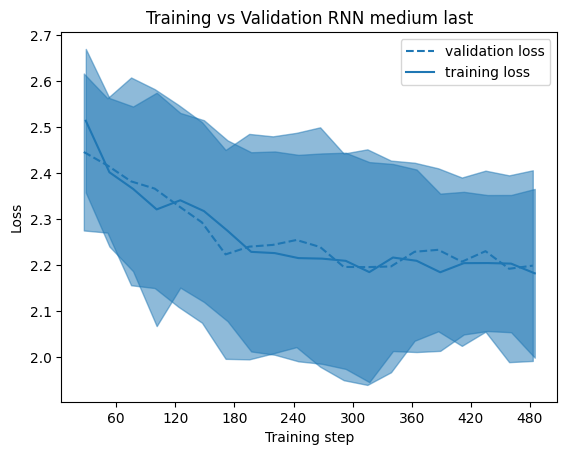

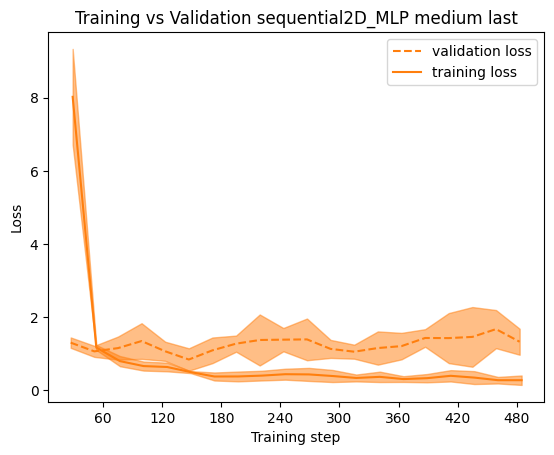

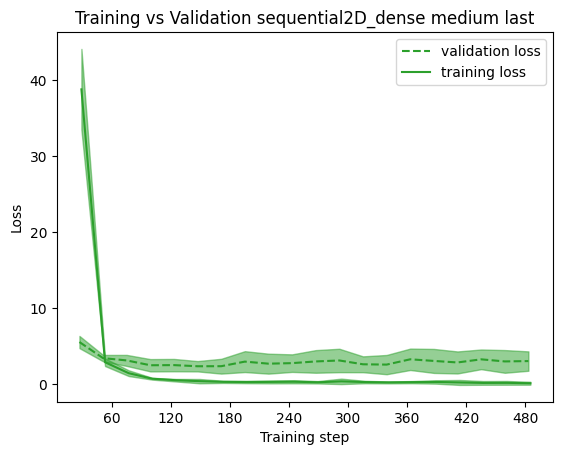

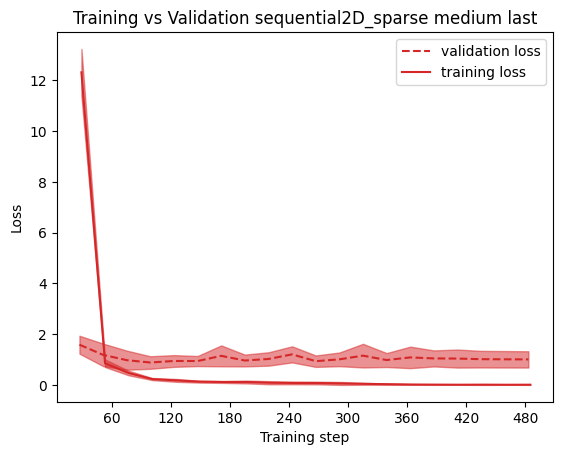

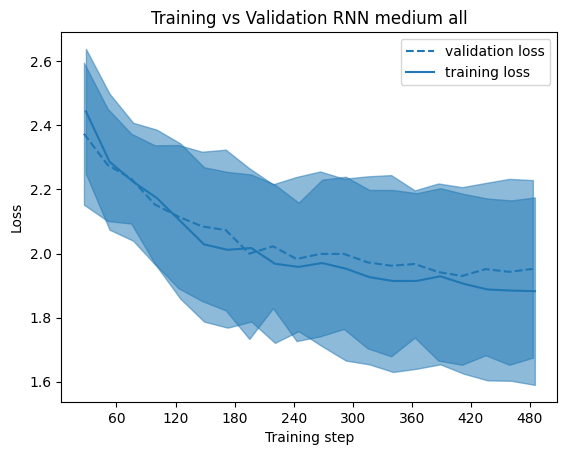

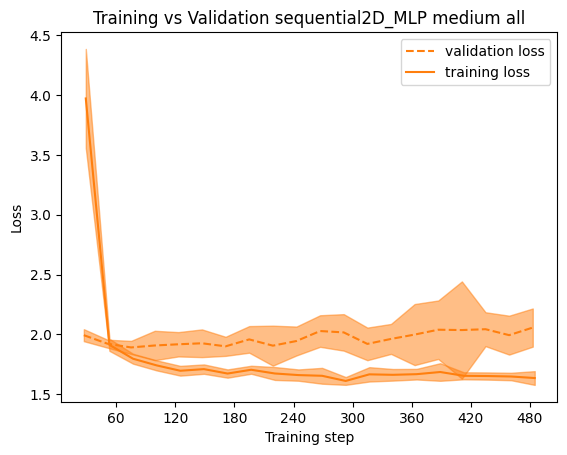

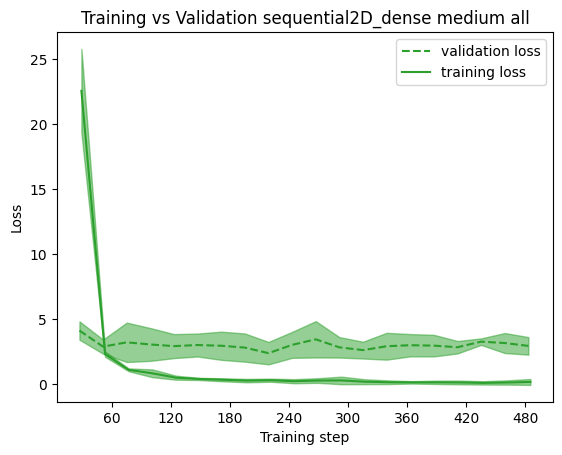

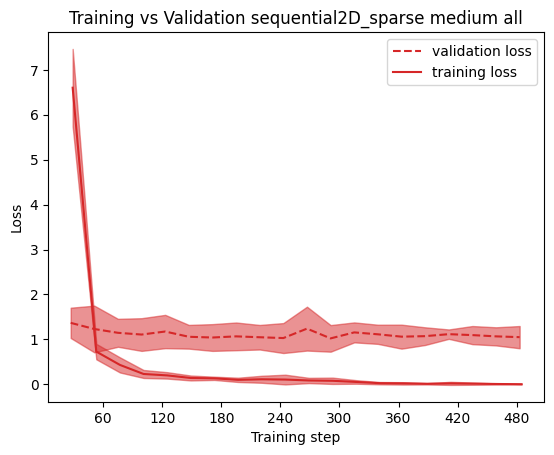

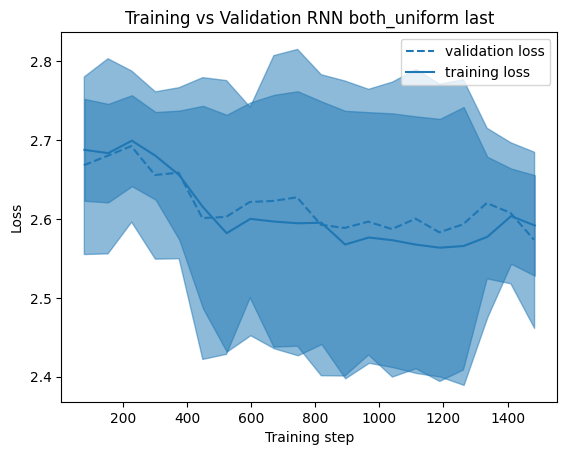

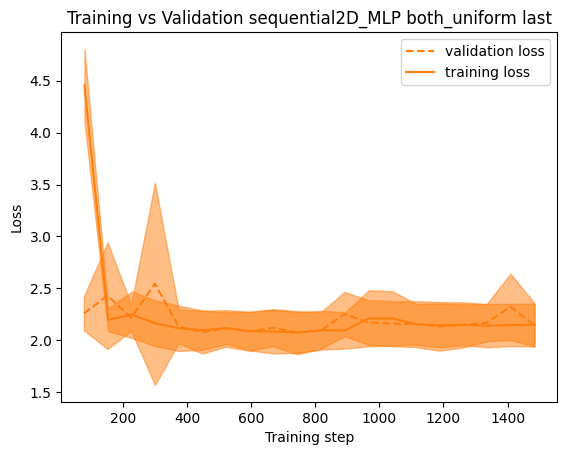

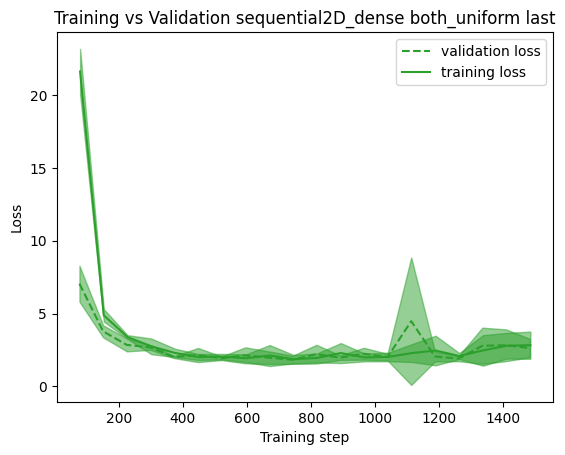

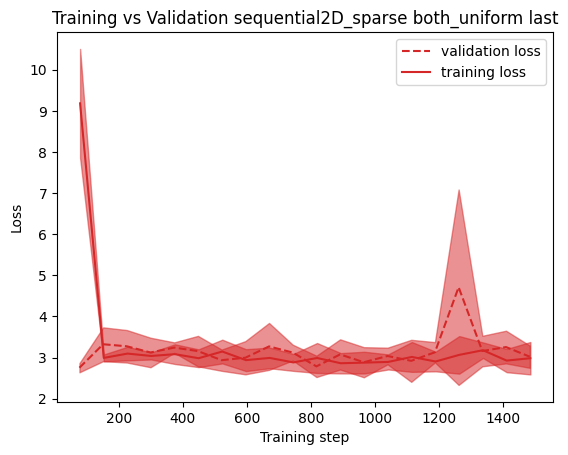

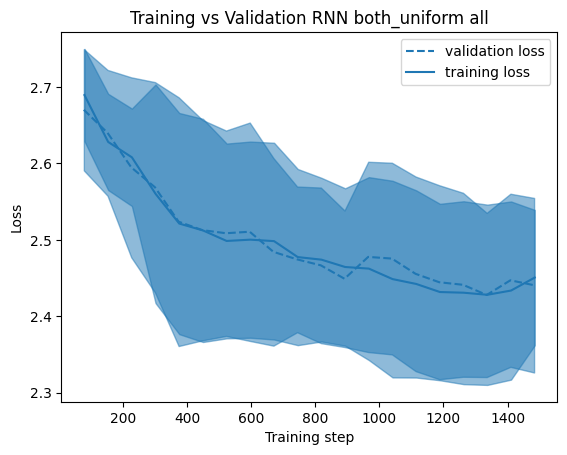

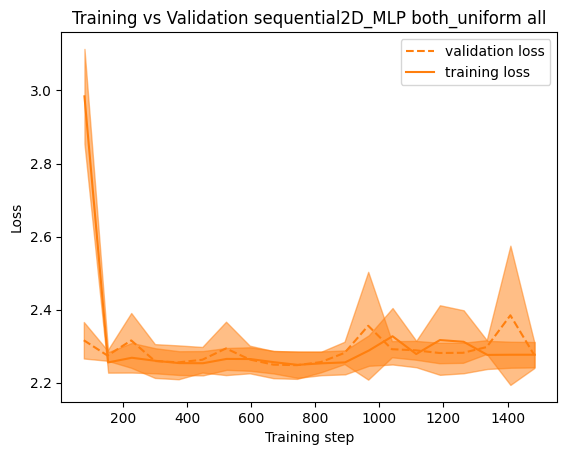

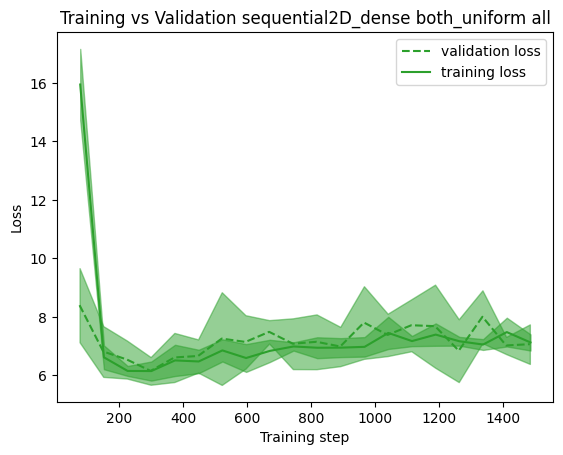

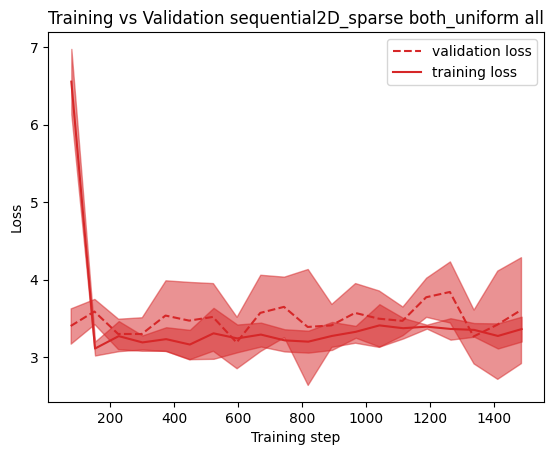

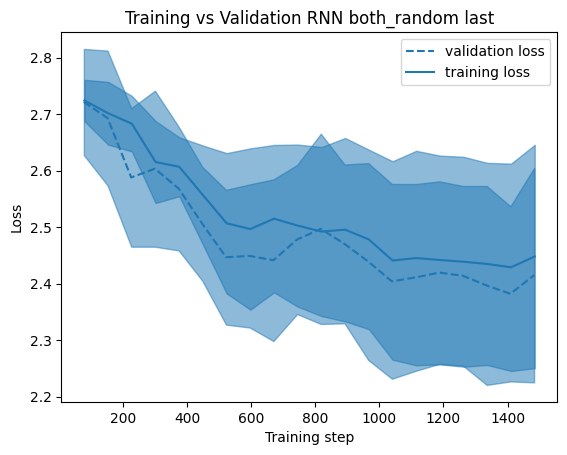

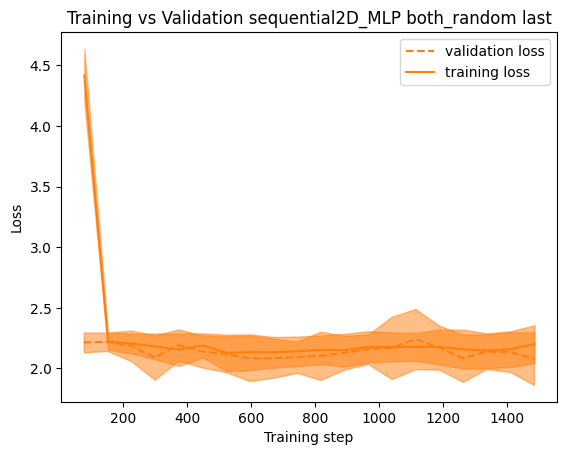

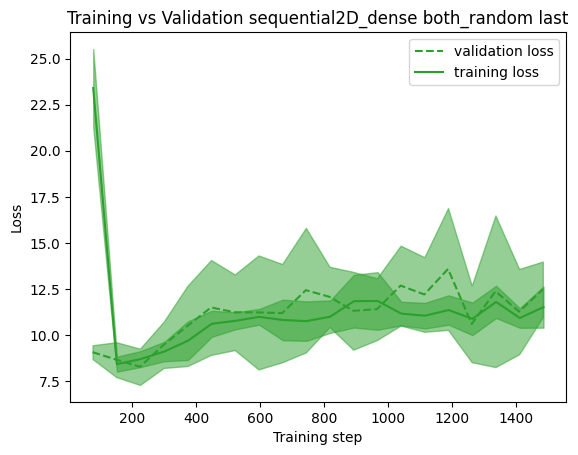

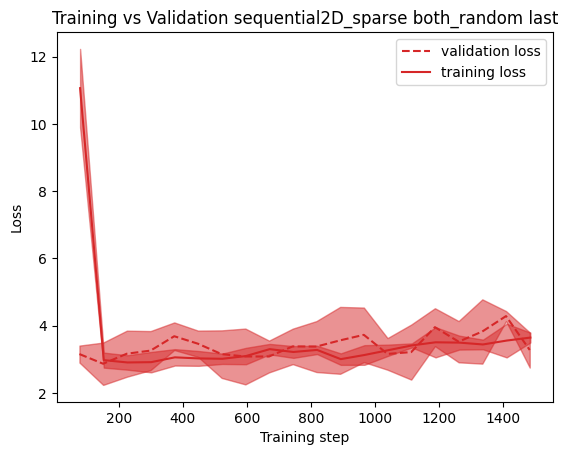

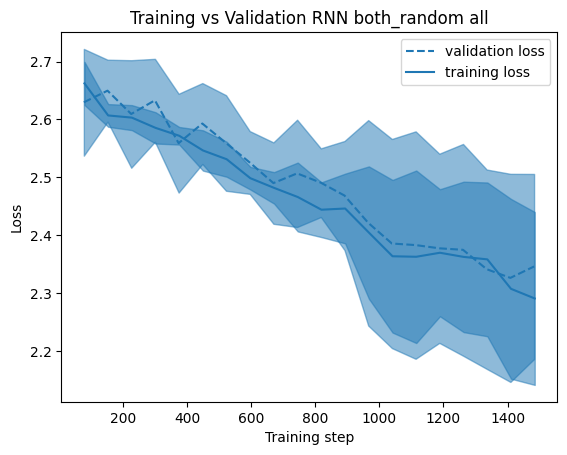

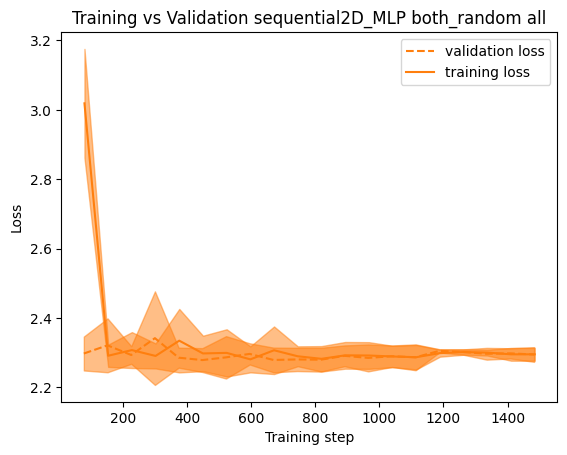

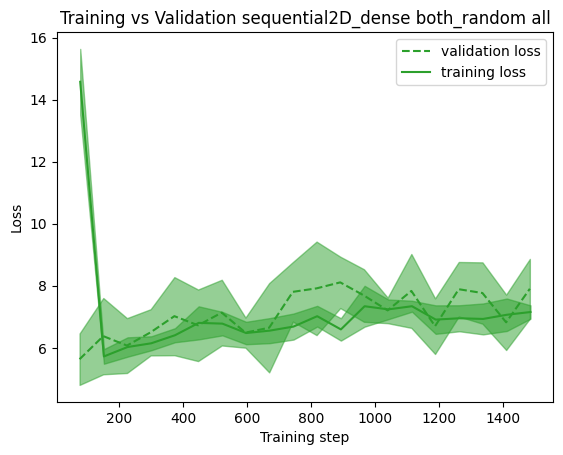

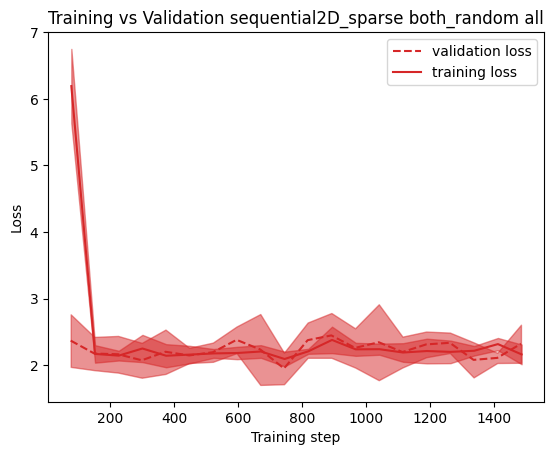

In [7]:
def training_validation_comparison():
    for data in datas:
        for eval_loss in eval_losses:
            for model,color in zip(models, my_colors):
                f = plt.figure()
                name = f'Training vs Validation {model} {data} {eval_loss}'
                ax = setup_plot(title=name, ylabel='Loss')

                Y = df[(df['model']== model) & 
                       (df['data'] == data) & 
                       (df['eval_loss'] == eval_loss)]['validation_loss'].values
                Y = np.array(Y.tolist())
                error_plot(ax, Y, label='validation loss', color=color, symbol='--')

                Y = df[(df['model']== model) & 
                       (df['data'] == data) & 
                       (df['eval_loss'] == eval_loss)]['training_loss'].values
                Y = np.array(Y.tolist())
                error_plot(ax, Y, label='training loss', color=color, symbol='-')

                plt.legend()
                to_latex(f, tex_file, name)

training_validation_comparison()

## Fixed data, various models

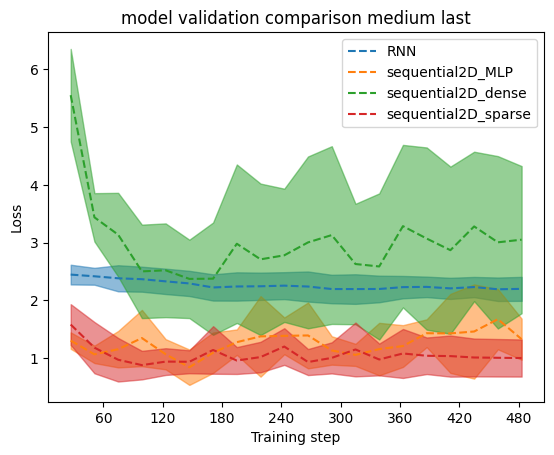

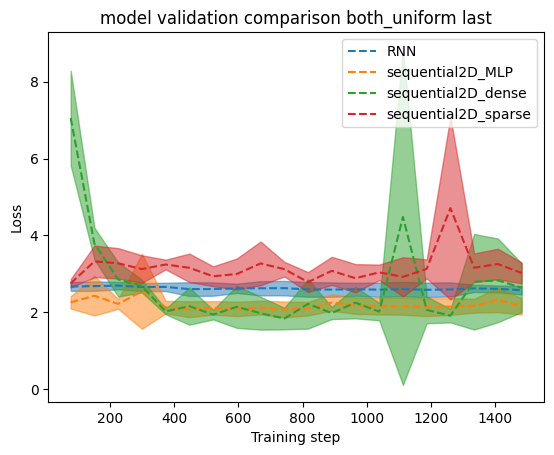

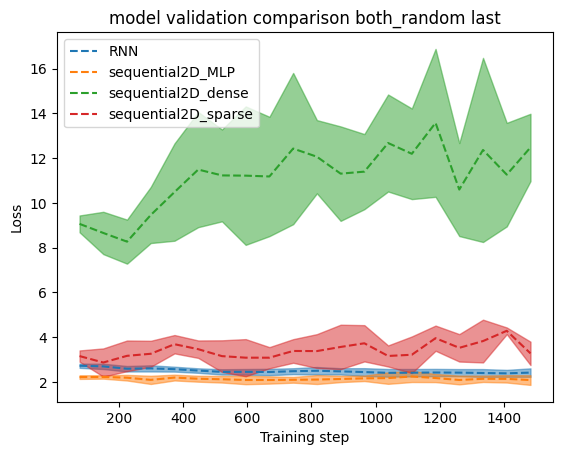

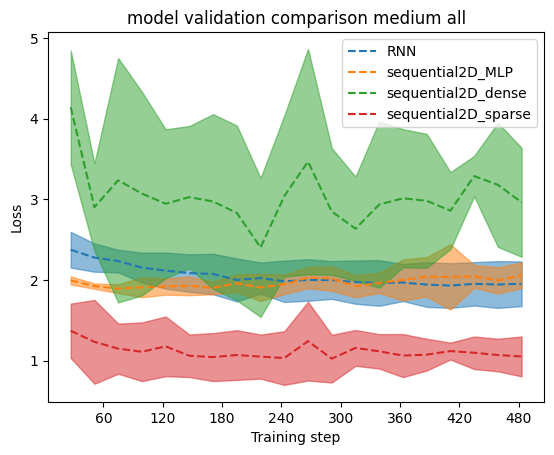

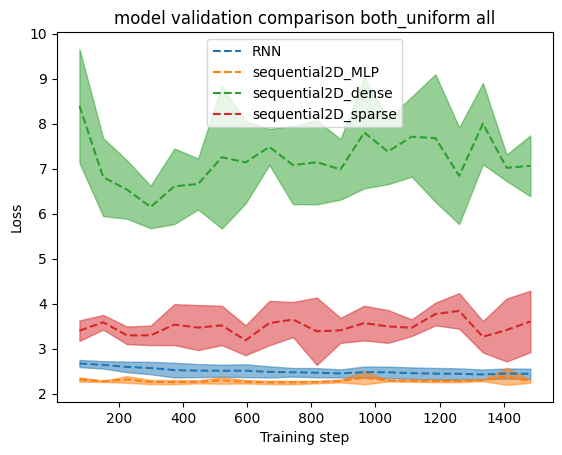

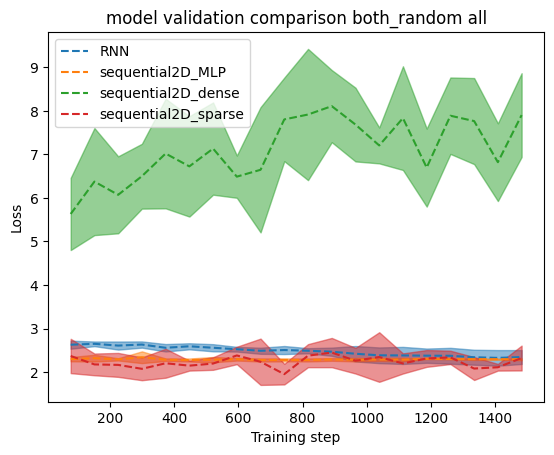

In [8]:
def model_validation_comaparison():
    for eval_loss in eval_losses:
       for data in datas:
            f = plt.figure()
            name = f'model validation comparison {data} {eval_loss}'
            ax = setup_plot(title=name, ylabel='Loss')
            for model,color in zip(models, my_colors):
                Y = df[(df['model']== model) & 
                       (df['data'] == data) & 
                       (df['eval_loss'] == eval_loss)]['validation_loss'].values
                Y = np.array(Y.tolist())
                error_plot(ax, Y, label=model, color=color, symbol='--')

            plt.legend()
            to_latex(f, tex_file, name)

model_validation_comaparison()

## A few iteration visualizations

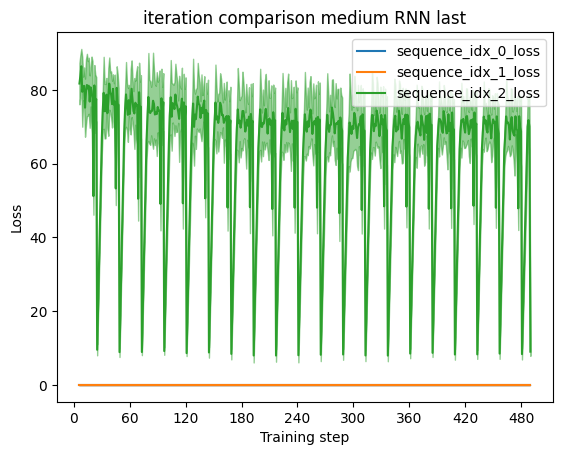

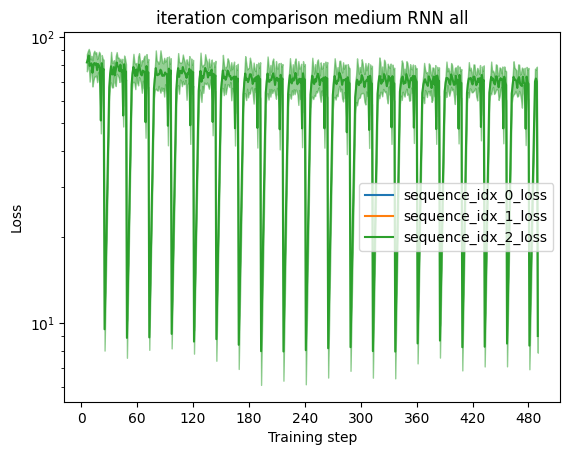

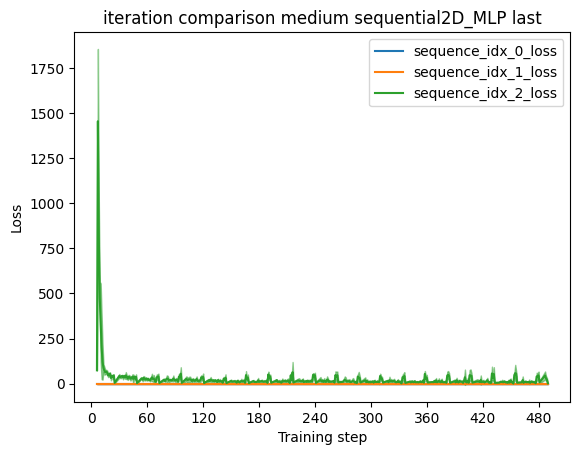

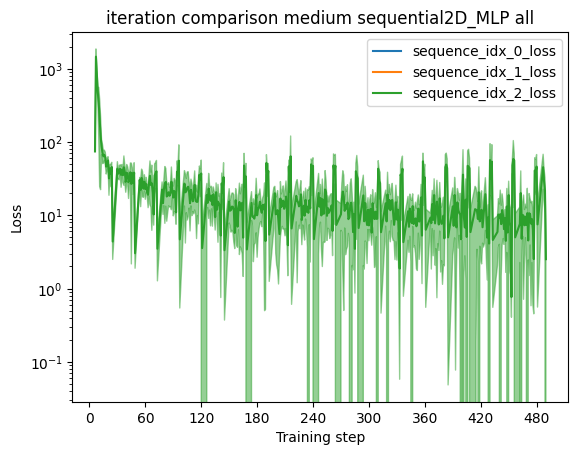

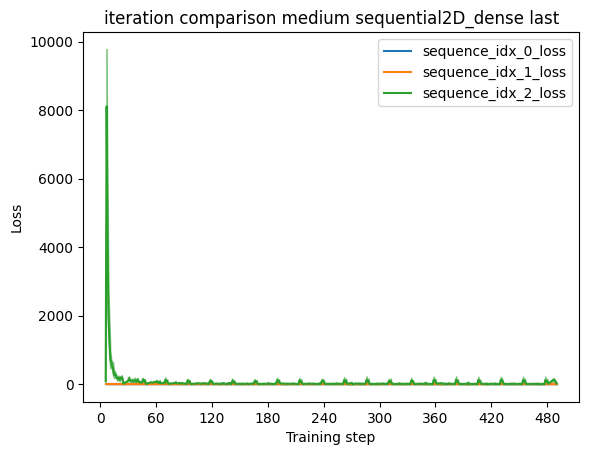

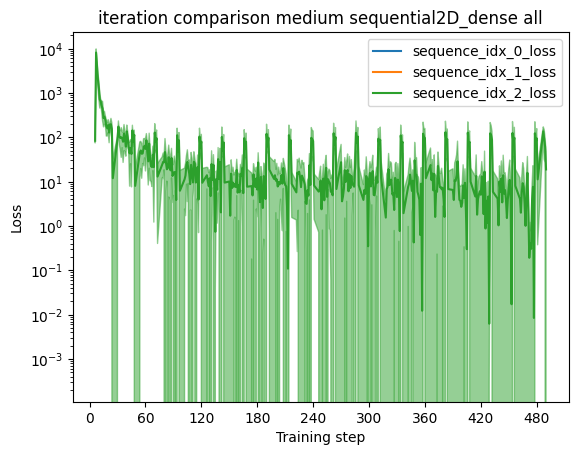

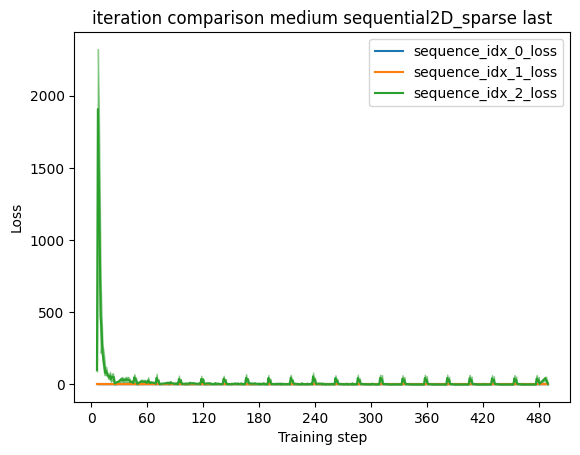

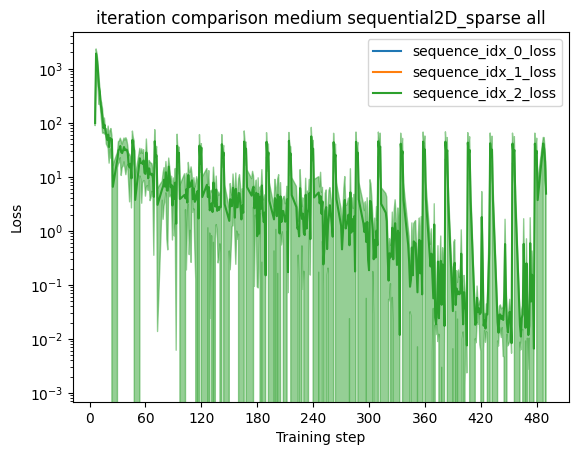

In [9]:
def model_validation_comaparison():
    for data in ['medium']:
        for model in models:
            for eval_loss in eval_losses:
                f = plt.figure()
                name = f'iteration comparison {data} {model} {eval_loss}'
                if eval_loss == 'all':
                    ax = setup_plot(title=name, ylabel='Loss', yscale='log')
                else:
                    ax = setup_plot(title=name, ylabel='Loss')
                for loss,color in zip(['sequence_idx_0_loss','sequence_idx_1_loss','sequence_idx_2_loss'], my_colors):
                    Y = df[(df['model']== model) & 
                        (df['data'] == data) & 
                        (df['eval_loss'] == 'last')][loss].values
                    Y = np.array(Y.tolist())
                    error_plot(ax, Y, label=loss, color=color, symbol='-')

                plt.legend()
                to_latex(f, tex_file, name)

model_validation_comaparison()

## All vs last

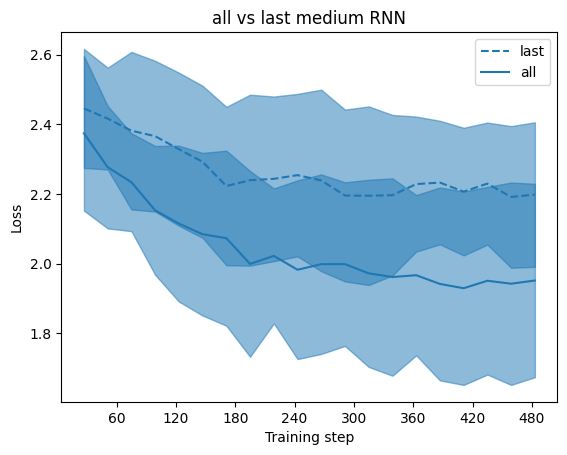

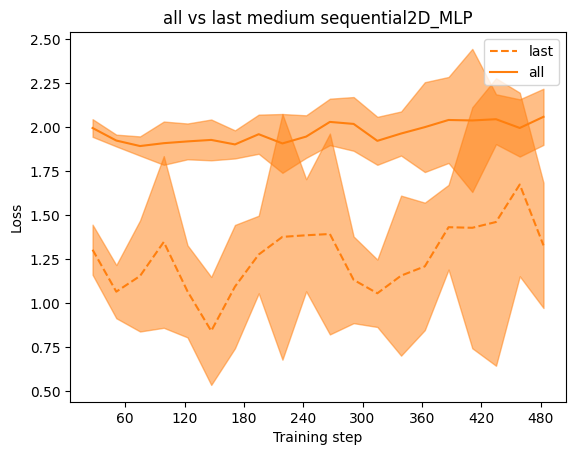

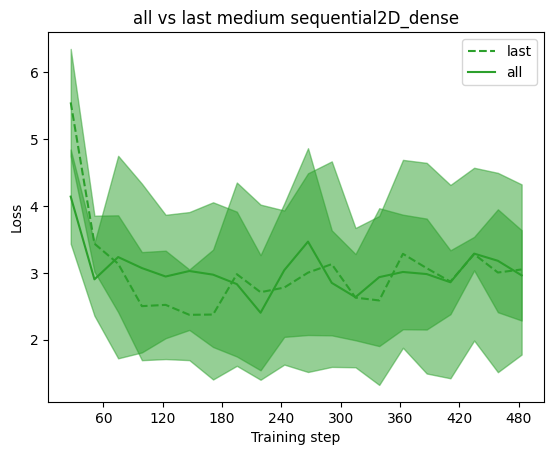

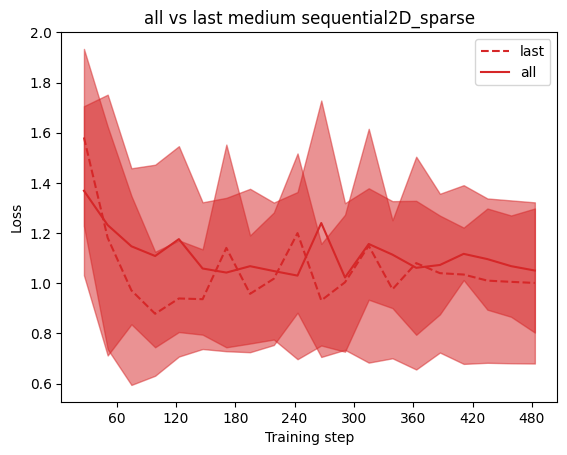

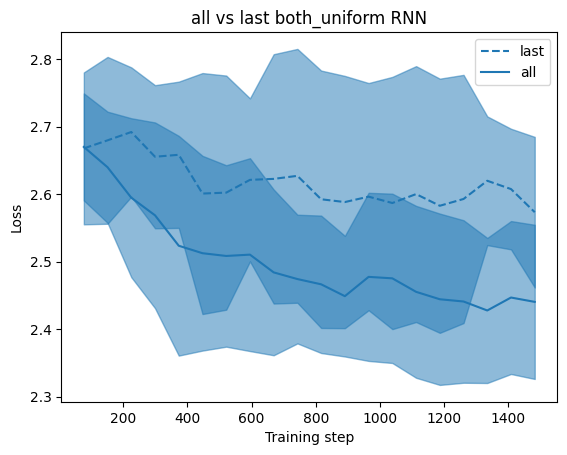

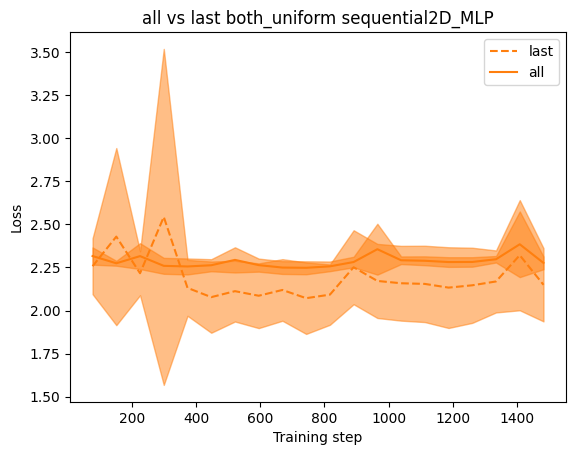

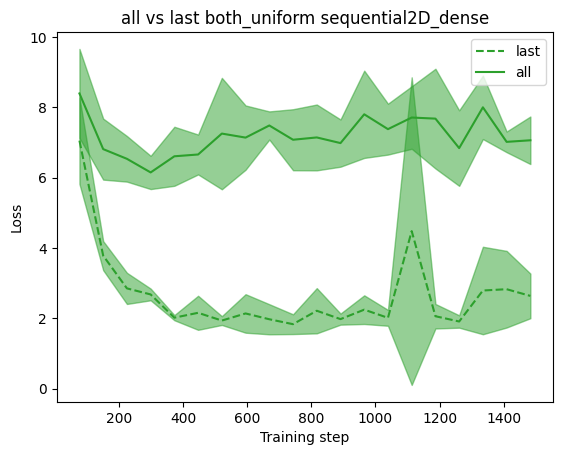

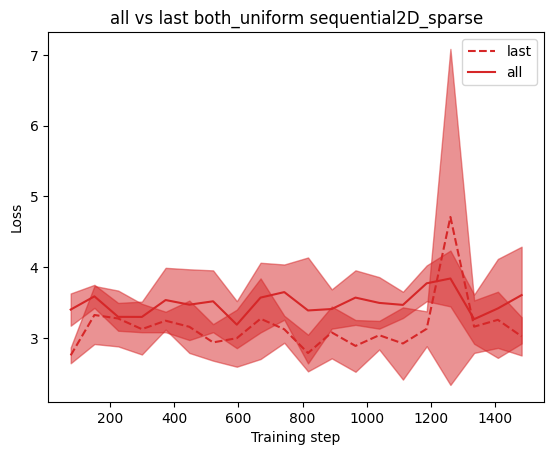

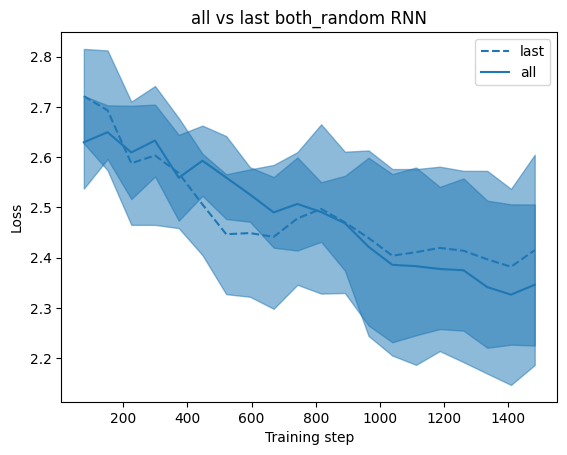

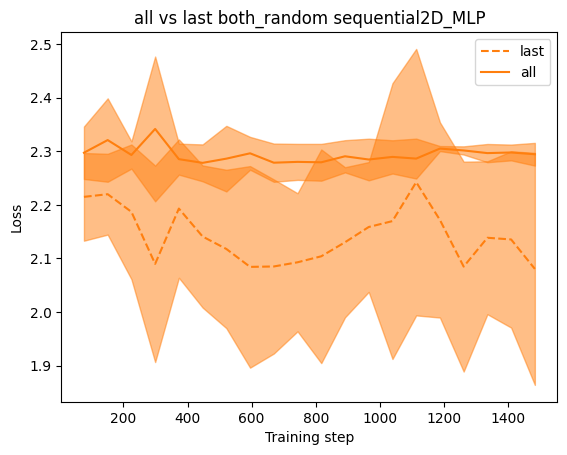

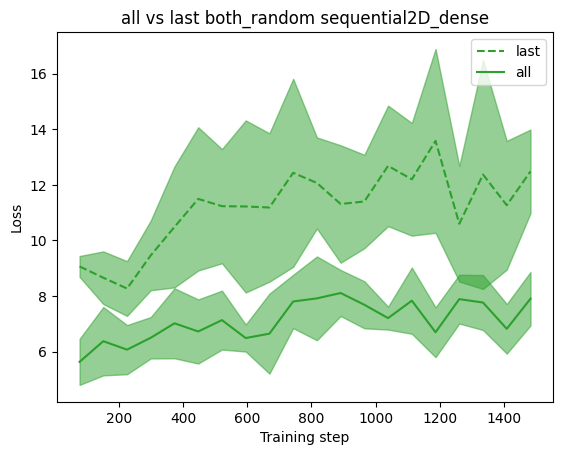

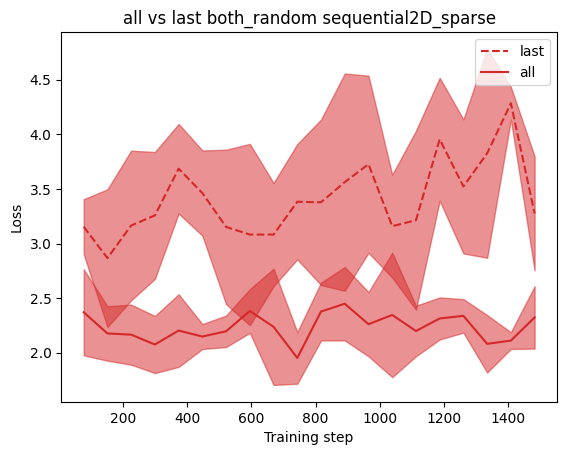

In [10]:
def model_validation_comaparison():
    for data in datas:
        for model,color in zip(models, my_colors):
            f = plt.figure()
            name = f'all vs last {data} {model}'
            ax = setup_plot(title=name, ylabel='Loss')
            for eval_loss in eval_losses:
                Y = df[(df['model']== model) & 
                        (df['data'] == data) & 
                        (df['eval_loss'] == eval_loss)]['validation_loss'].values
                Y = np.array(Y.tolist())
                if eval_loss == 'all':
                    error_plot(ax, Y, label=eval_loss, color=color, symbol='-')
                else:
                    error_plot(ax, Y, label=eval_loss, color=color, symbol='--')

            plt.legend()
            to_latex(f, tex_file, name)

model_validation_comaparison()